In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5283, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 5283 (delta 393), reused 321 (delta 269), pack-reused 4811
Receiving objects: 100% (5283/5283), 2.86 GiB | 24.84 MiB/s, done.
Resolving deltas: 100% (4219/4219), done.
Updating files: 100% (474/474), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 13.3 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 19.9 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_all.zip
/kaggle/input/training-tuned-models/custom.css
/kag

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 50,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

'/kaggle/working/slim_recall_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4999.20 column/sec. Elapsed time 4.47 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5456.21 column/sec. Elapsed time 2.39 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3449.02 column/sec. Elapsed time 6.48 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3852.53 column/sec. Elapsed time 5.80 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [26]:
print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 7.56 sec. Users per second: 1383


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081236,0.139185,0.117504,0.039511,0.068781,0.237517,0.127531,0.09606,0.475899,0.303733,...,0.802826,0.382064,0.802826,0.090882,10.724402,0.998438,0.265776,0.826934,1.502888,0.3873


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 7.39 sec. Users per second: 1415


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 7.50 sec. Users per second: 1395


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 7.33 sec. Users per second: 1426


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 10.88 sec. Users per second: 961


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061448,0.112121,0.096632,0.028523,0.05183,0.190388,0.099346,0.075124,0.40637,0.231987,...,0.802826,0.326244,0.802826,0.011369,7.734762,0.986162,0.033249,0.59641,3.662908,0.323456


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 9.32 sec. Users per second: 1121


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 8.90 sec. Users per second: 1175


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 11.17 sec. Users per second: 936


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 12.30 sec. Users per second: 850


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 8.46 sec. Users per second: 1235


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 10.69 sec. Users per second: 978


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 11.46 sec. Users per second: 912


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07523,0.130395,0.110728,0.036193,0.063731,0.2264,0.119463,0.089591,0.46031,0.284432,...,0.802826,0.369549,0.802826,0.030039,9.477048,0.99708,0.087846,0.730753,2.146813,0.353406


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 12.17 sec. Users per second: 859


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


In [27]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [28]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [29]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [30]:
training_dataframe.Label.sum()

15808

In [31]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [32]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [34]:
tmp.ItemID.values.astype(int)

array([  35,  100,  505,  428,  591,  693,  402, 1480,  122,  617,  976,
        868,    3,  514,  111,    2,  636, 1545,  256,  341,  336, 1629,
        101,    9,   84,    1,    0, 1421,  849, 1287, 1934, 1082, 1213,
         53,   28,  288, 1056,   57,   76,   75,  921,   86, 1337, 2498,
        772,  136,  283,  533,   97,  155])

In [35]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([    0,     1,     2,    12,     3,     4,     6,     5,     9,
           7,    48,  8149,  7494,    26,    50,  7493,    39,    11,
        7688,     8,  7638,    29,    27,  7499,  7528,  7492, 21981,
          10,    43,    14,    41,    13,    16,  7541,  7474,  7590,
          23,  7545,  7520,    34,    60,  7530,    15,  6457,    33,
        7424,  7585,  7088,  7411,    45])

In [36]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [37]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,EaseR_RankPosition,EaseR_Recommended,IALS_Score,IALS_RankPosition,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,0.0,1.0,0.417650,1.0,1.0,10,15.583333,47.269937,3.410209,11.713514
1,0,100,False,0.550739,1.0,1.0,0.010197,166.0,0.0,0.551174,...,1.0,1.0,0.495697,0.0,1.0,11,14.333333,47.765209,3.463424,11.996610
2,0,505,False,0.524022,2.0,1.0,0.063451,58.0,0.0,0.354394,...,2.0,1.0,0.363251,2.0,1.0,11,7.416667,15.985552,3.421667,11.781373
3,0,428,False,0.242514,12.0,0.0,0.005722,180.0,0.0,0.167343,...,3.0,1.0,0.258930,4.0,1.0,4,32.916667,49.540540,2.763890,8.306912
4,0,591,False,0.513606,3.0,1.0,0.069904,43.0,0.0,0.260866,...,5.0,1.0,0.173614,19.0,0.0,6,55.333333,128.699321,3.293670,11.092738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,44.0,0.0,0.135079,134.0,0.0,2,55.583333,41.306963,0.694051,0.073197
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,130.0,0.0,0.313277,14.0,0.0,3,52.583333,43.160290,0.399351,-1.101373
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,38.0,0.0,0.240429,36.0,0.0,1,283.583333,466.950349,2.764785,8.336565
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,26.0,0.0,0.257621,30.0,0.0,0,1380.166667,3092.025545,2.055036,2.641748


In [38]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,1.0,10,15.583333,47.269937,3.410209,11.713514,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,1.0,1.0,0.010197,166.0,0.0,0.551174,...,1.0,11,14.333333,47.765209,3.463424,11.996610,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,2.0,1.0,0.063451,58.0,0.0,0.354394,...,1.0,11,7.416667,15.985552,3.421667,11.781373,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,12.0,0.0,0.005722,180.0,0.0,0.167343,...,1.0,4,32.916667,49.540540,2.763890,8.306912,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,3.0,1.0,0.069904,43.0,0.0,0.260866,...,0.0,6,55.333333,128.699321,3.293670,11.092738,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,0.0,2,55.583333,41.306963,0.694051,0.073197,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.0,3,52.583333,43.160290,0.399351,-1.101373,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,0.0,1,283.583333,466.950349,2.764785,8.336565,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,0.0,0,1380.166667,3092.025545,2.055036,2.641748,0.047915,0.055156,53.265190,112.935230


In [39]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.0,1.0,0.010529,165.0,0.0,0.804430,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,10.0,0.0,0.000823,580.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,43.0,0.0,0.002299,237.0,0.0,0.063939,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,14.0,0.0,0.068837,46.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,41.0,0.0,0.033073,104.0,0.0,0.061394,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,106.0,0.0,0.059093,621.0,0.0,0.086976,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,48.0,0.0,0.219686,48.0,0.0,0.049547,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,53.0,0.0,0.026436,2196.0,0.0,0.096624,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,30.0,0.0,0.353050,8.0,1.0,0.167004,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [40]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [41]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [42]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label", "UserID", "ItemID"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

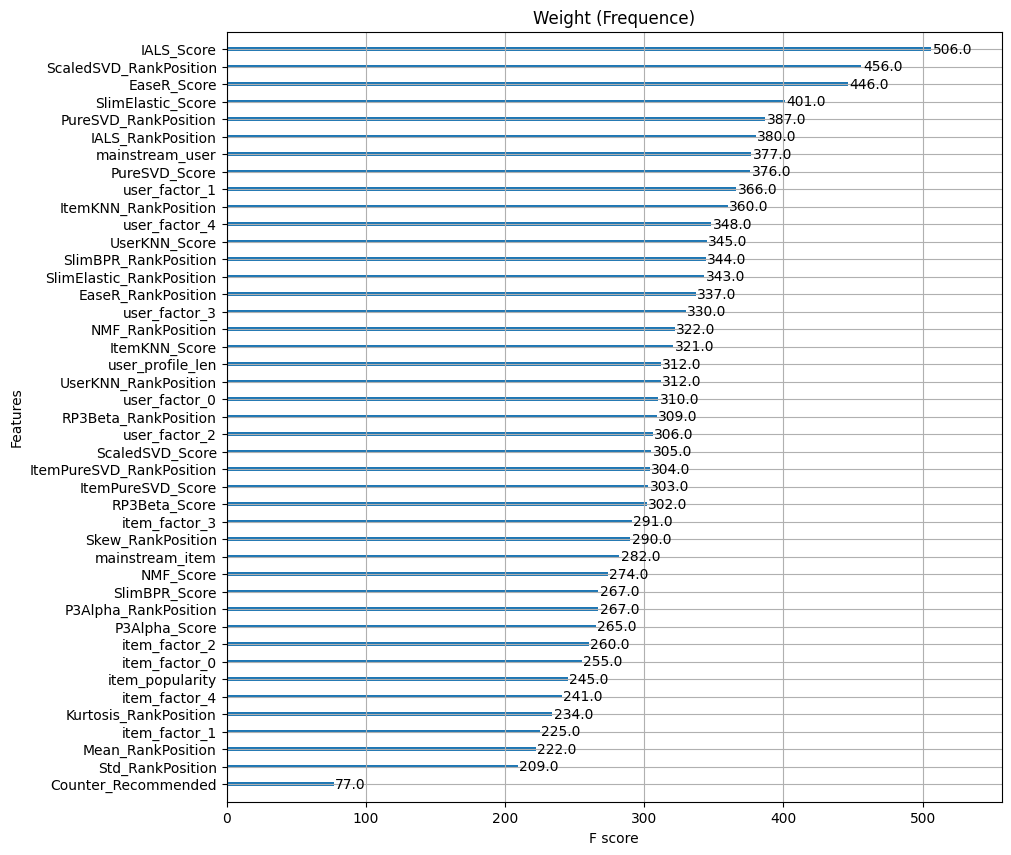

In [43]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [44]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4740.02 column/sec. Elapsed time 4.71 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4823.86 column/sec. Elapsed time 2.70 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3096.13 column/sec. Elapsed time 7.22 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3607.62 column/sec. Elapsed time 6.19 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [45]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [46]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_19/907138705.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,IALS_Score,IALS_RankPosition,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,35,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,0.0,...,0.514264,1.0,1.0,9,5.416667,11.965544,2.811490,8.360512,0.406406,0.032075
1,0,100,0.830547,1.0,1.0,0.033586,45.0,0.0,0.744487,1.0,...,0.621994,0.0,1.0,11,4.416667,12.788193,3.456490,11.962273,0.237011,0.032075
2,0,505,0.471617,3.0,1.0,0.015319,49.0,0.0,0.288312,3.0,...,0.371543,3.0,1.0,11,8.083333,13.104186,3.265812,10.977512,0.074733,0.032075
3,0,51,0.213902,19.0,0.0,0.004863,159.0,0.0,0.111361,14.0,...,0.177052,23.0,0.0,6,21.416667,44.038121,3.269864,11.014058,0.202135,0.032075
4,0,402,0.598366,2.0,1.0,0.013870,50.0,0.0,0.283639,4.0,...,0.426898,2.0,1.0,8,10.833333,14.640128,2.165462,4.518015,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,59.0,0.0,0.059399,687.0,0.0,0.057316,77.0,...,0.307450,25.0,0.0,2,98.666667,188.834383,3.245945,10.847786,0.113879,0.056604
651196,13023,852,0.056650,89.0,0.0,0.338165,19.0,0.0,0.000000,8068.0,...,0.274723,39.0,0.0,0,1392.500000,3127.692338,2.054632,2.638664,0.054093,0.056604
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.339215,19.0,0.0,0,813.250000,2373.983615,3.421945,11.778180,0.054804,0.056604
651198,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.227916,65.0,0.0,0,235.083333,415.592339,2.397963,5.376126,0.004982,0.056604


In [47]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,0.0,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,7533.0,0.0,0.008853,70.0,0.0,0.000000,7509.0,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,55.0,0.0,0.008037,80.0,0.0,0.094083,21.0,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,15.0,0.0,0.002795,372.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,7520.0,0.0,0.137722,155.0,0.0,0.000000,7480.0,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,5.0,1.0,0.567250,0.0,1.0,0.406934,8.0,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,16.0,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [48]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [49]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice.drop(columns=["UserID", "ItemID"]))
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [50]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 2.15 min. Users per second: 81


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.09694,0.166954,0.140966,0.048628,0.0822,0.267314,0.150002,0.114879,0.52697,0.356059,...,0.802826,0.423065,0.802826,0.047792,9.995707,0.997201,0.137899,0.77003,2.001879,0.292764


In [51]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [52]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost_no_ids.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [53]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-20 21:57:06,738] Using an existing study with name 'xgboost_tuning' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.09 min. Users per second: 83


[I 2023-12-20 22:00:53,007] Trial 50 finished with value: 0.051738763951130674 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 772, 'learning_rate': 0.01883650468328685, 'reg_alpha': 0.040087542630625674, 'reg_lambda': 0.0024232956751765165, 'max_depth': 3, 'max_leaves': 714, 'grow_policy': 'lossguide', 'gamma': 3.81235675127188, 'min_child_weight': 2.2914634698334897e-06, 'subsample': 0.43544321268264985, 'colsample_bytree': 0.7498952804967943}. Best is trial 45 with value: 0.05190504274905641.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.19 min. Users per second: 79


[I 2023-12-20 22:04:55,726] Trial 51 finished with value: 0.05164844594430539 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 819, 'learning_rate': 0.019239213290878552, 'reg_alpha': 0.04727641327999122, 'reg_lambda': 0.0034275191473721674, 'max_depth': 3, 'max_leaves': 720, 'grow_policy': 'lossguide', 'gamma': 4.2600946199893, 'min_child_weight': 2.5841054826539397e-06, 'subsample': 0.3979982332357411, 'colsample_bytree': 0.7597329530249723}. Best is trial 45 with value: 0.05190504274905641.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.29 min. Users per second: 76


[I 2023-12-20 22:08:38,711] Trial 52 finished with value: 0.05133326653793426 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 505, 'learning_rate': 0.0253212223212907, 'reg_alpha': 0.020935692945012685, 'reg_lambda': 0.0022616557266993253, 'max_depth': 6, 'max_leaves': 496, 'grow_policy': 'lossguide', 'gamma': 4.1977484555501015, 'min_child_weight': 1.7144552591605086e-06, 'subsample': 0.4367234833921429, 'colsample_bytree': 0.8591027618571486}. Best is trial 45 with value: 0.05190504274905641.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.29 min. Users per second: 76


[I 2023-12-20 22:13:25,803] Trial 53 finished with value: 0.05190954764333752 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1067, 'learning_rate': 0.017154985108736663, 'reg_alpha': 0.008208720688021542, 'reg_lambda': 0.0012410167695725504, 'max_depth': 4, 'max_leaves': 709, 'grow_policy': 'lossguide', 'gamma': 1.1714244282069515, 'min_child_weight': 1.1560271489936724e-06, 'subsample': 0.36941151381630016, 'colsample_bytree': 0.8169956091751052}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.22 min. Users per second: 78


[I 2023-12-20 22:17:58,412] Trial 54 finished with value: 0.0517642486732011 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1006, 'learning_rate': 0.0335617367699851, 'reg_alpha': 0.008390552608841695, 'reg_lambda': 0.0012676299426053657, 'max_depth': 4, 'max_leaves': 603, 'grow_policy': 'lossguide', 'gamma': 1.1266406531140758, 'min_child_weight': 1.040769883731334e-06, 'subsample': 0.3758452182557127, 'colsample_bytree': 0.8118431343901629}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 67


[I 2023-12-20 22:25:12,000] Trial 55 finished with value: 0.05179572980046452 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1845, 'learning_rate': 0.006394036457721153, 'reg_alpha': 0.005328819796328919, 'reg_lambda': 0.0010163939453917395, 'max_depth': 5, 'max_leaves': 439, 'grow_policy': 'lossguide', 'gamma': 0.3599396807891286, 'min_child_weight': 8.676169403242081e-06, 'subsample': 0.3526881431871224, 'colsample_bytree': 0.8669866220498899}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.36 min. Users per second: 52


[I 2023-12-20 22:35:17,257] Trial 56 finished with value: 0.04273798517749423 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1960, 'learning_rate': 0.008153161126081407, 'reg_alpha': 0.0035662941785106162, 'reg_lambda': 0.0048911853591756945, 'max_depth': 8, 'max_leaves': 409, 'grow_policy': 'lossguide', 'gamma': 0.0664576400207882, 'min_child_weight': 1.0615678437131738e-05, 'subsample': 0.38096096505100796, 'colsample_bytree': 0.8711043660647574}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.82 min. Users per second: 62


[I 2023-12-20 22:44:59,700] Trial 57 finished with value: 0.05077283795436119 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2567, 'learning_rate': 0.00611073925901975, 'reg_alpha': 0.0028192199961814724, 'reg_lambda': 0.002838995896958615, 'max_depth': 5, 'max_leaves': 457, 'grow_policy': 'lossguide', 'gamma': 0.023149273004288356, 'min_child_weight': 2.1192796885878675e-05, 'subsample': 0.33033843859647094, 'colsample_bytree': 0.8977090291927068}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.57 min. Users per second: 68


[I 2023-12-20 22:50:54,297] Trial 58 finished with value: 0.05160763243706118 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1197, 'learning_rate': 0.00598061722392897, 'reg_alpha': 0.005639527994922836, 'reg_lambda': 0.0020558149715476193, 'max_depth': 6, 'max_leaves': 799, 'grow_policy': 'lossguide', 'gamma': 0.5146192367762155, 'min_child_weight': 5.055491828381319e-06, 'subsample': 0.3772041916641839, 'colsample_bytree': 0.8033878641302459}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.46 min. Users per second: 71


[I 2023-12-20 23:00:10,279] Trial 59 finished with value: 0.051846980088899174 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3211, 'learning_rate': 0.010284599619568405, 'reg_alpha': 0.013483823969862632, 'reg_lambda': 0.0014818517571965472, 'max_depth': 3, 'max_leaves': 520, 'grow_policy': 'depthwise', 'gamma': 0.22143882031925366, 'min_child_weight': 1.1342257841041874e-05, 'subsample': 0.4178351292185981, 'colsample_bytree': 0.8310665725997799}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.69 min. Users per second: 65


[I 2023-12-20 23:09:49,337] Trial 60 finished with value: 0.05184809967088148 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3017, 'learning_rate': 0.013399693789143682, 'reg_alpha': 0.014785922808615766, 'reg_lambda': 0.0016011802970845707, 'max_depth': 4, 'max_leaves': 608, 'grow_policy': 'depthwise', 'gamma': 0.17355103040220696, 'min_child_weight': 1.9476581608296542e-05, 'subsample': 0.49514910594166905, 'colsample_bytree': 0.7761301323676683}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 67


[I 2023-12-20 23:21:16,805] Trial 61 finished with value: 0.051880563753173466 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4240, 'learning_rate': 0.01027863148591569, 'reg_alpha': 0.013318778612411972, 'reg_lambda': 0.0017405923586353315, 'max_depth': 3, 'max_leaves': 609, 'grow_policy': 'depthwise', 'gamma': 0.22182733097044224, 'min_child_weight': 2.3394206066898124e-05, 'subsample': 0.4239849187171605, 'colsample_bytree': 0.8277945178689414}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.74 min. Users per second: 64


[I 2023-12-20 23:32:58,762] Trial 62 finished with value: 0.05184823629783524 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4264, 'learning_rate': 0.008801115836910458, 'reg_alpha': 0.008603138271760246, 'reg_lambda': 0.0057522681722467625, 'max_depth': 3, 'max_leaves': 615, 'grow_policy': 'depthwise', 'gamma': 0.06263913349736178, 'min_child_weight': 2.08299985165604e-05, 'subsample': 0.4260421672085707, 'colsample_bytree': 0.7746185671089888}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.69 min. Users per second: 65


[I 2023-12-20 23:46:09,755] Trial 63 finished with value: 0.05187247240135593 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4982, 'learning_rate': 0.015181806126430214, 'reg_alpha': 0.010096770296600117, 'reg_lambda': 0.011283153148412186, 'max_depth': 3, 'max_leaves': 621, 'grow_policy': 'depthwise', 'gamma': 0.07296149372913978, 'min_child_weight': 4.920470990917782e-05, 'subsample': 0.4935913872368095, 'colsample_bytree': 0.7874662471395311}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.66 min. Users per second: 66


[I 2023-12-20 23:58:38,170] Trial 64 finished with value: 0.05187326939191965 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4669, 'learning_rate': 0.008602916487835795, 'reg_alpha': 0.009455681038332291, 'reg_lambda': 0.012784139722607814, 'max_depth': 3, 'max_leaves': 692, 'grow_policy': 'depthwise', 'gamma': 0.07676585948750482, 'min_child_weight': 4.239425038184576e-05, 'subsample': 0.4669109240845541, 'colsample_bytree': 0.7327756157463052}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.44 min. Users per second: 71


[I 2023-12-21 00:07:31,059] Trial 65 finished with value: 0.05168098972565378 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2994, 'learning_rate': 0.0043660302273595365, 'reg_alpha': 0.006849833124999907, 'reg_lambda': 0.011486202177474066, 'max_depth': 3, 'max_leaves': 684, 'grow_policy': 'depthwise', 'gamma': 0.03441928205944328, 'min_child_weight': 5.294584828446519e-05, 'subsample': 0.4473393199130716, 'colsample_bytree': 0.7282379257888952}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.50 min. Users per second: 50


[I 2023-12-21 00:23:00,068] Trial 66 finished with value: 0.046483996429482984 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4769, 'learning_rate': 0.012098959168991629, 'reg_alpha': 0.0024664139964647377, 'reg_lambda': 0.027135756332263495, 'max_depth': 5, 'max_leaves': 776, 'grow_policy': 'depthwise', 'gamma': 0.013273088522030541, 'min_child_weight': 9.506676171209417e-05, 'subsample': 0.476182674916011, 'colsample_bytree': 0.7997156267474032}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.64 min. Users per second: 66


[I 2023-12-21 00:33:55,275] Trial 67 finished with value: 0.051901573942507905 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3919, 'learning_rate': 0.01586187792169657, 'reg_alpha': 0.01274482570349357, 'reg_lambda': 0.039118256132779236, 'max_depth': 3, 'max_leaves': 770, 'grow_policy': 'depthwise', 'gamma': 0.034208829394260384, 'min_child_weight': 4.440205260483015e-06, 'subsample': 0.5006780822484589, 'colsample_bytree': 0.8200464818815323}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.52 min. Users per second: 69


[I 2023-12-21 00:44:44,316] Trial 68 finished with value: 0.05110091342709031 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3841, 'learning_rate': 0.014774875832993247, 'reg_alpha': 0.012570447810644534, 'reg_lambda': 0.03056850964724508, 'max_depth': 3, 'max_leaves': 772, 'grow_policy': 'depthwise', 'gamma': 0.08271177517976008, 'min_child_weight': 2.9324003875489823e-05, 'subsample': 0.5065503434562065, 'colsample_bytree': 0.81491913267839}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.69 min. Users per second: 65


[I 2023-12-21 00:58:22,135] Trial 69 finished with value: 0.05124719155706215 and parameters: {'objective': 'rank:map', 'n_estimators': 4988, 'learning_rate': 0.008030363684716496, 'reg_alpha': 0.006893904922989156, 'reg_lambda': 0.05091766057130485, 'max_depth': 3, 'max_leaves': 858, 'grow_policy': 'depthwise', 'gamma': 0.0252348252364665, 'min_child_weight': 4.385395260967138e-06, 'subsample': 0.48138429562626606, 'colsample_bytree': 0.7369579954534979}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.06 min. Users per second: 30
EvaluatorHoldout: Processed 10456 (100.0%) in 5.87 min. Users per second: 30


[I 2023-12-21 01:19:11,549] Trial 70 finished with value: 0.04173156446970585 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3731, 'learning_rate': 0.004844935305702118, 'reg_alpha': 0.0038081689978923887, 'reg_lambda': 0.010248531500045116, 'max_depth': 10, 'max_leaves': 675, 'grow_policy': 'depthwise', 'gamma': 0.09761037929085624, 'min_child_weight': 4.6987930539741686e-05, 'subsample': 0.4542741748519563, 'colsample_bytree': 0.7814038903195835}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.94 min. Users per second: 59


[I 2023-12-21 01:31:36,082] Trial 71 finished with value: 0.04736631432093434 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4095, 'learning_rate': 0.026413343345066367, 'reg_alpha': 0.008233020279396496, 'reg_lambda': 0.007053623111418299, 'max_depth': 4, 'max_leaves': 565, 'grow_policy': 'depthwise', 'gamma': 0.03475585265777, 'min_child_weight': 1.3730475720874478e-05, 'subsample': 0.399008607696022, 'colsample_bytree': 0.8756011009851625}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.77 min. Users per second: 63


[I 2023-12-21 01:40:19,660] Trial 72 finished with value: 0.050015909449727954 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2401, 'learning_rate': 0.01639493031649656, 'reg_alpha': 0.010963505375175953, 'reg_lambda': 0.003955434094851233, 'max_depth': 5, 'max_leaves': 754, 'grow_policy': 'depthwise', 'gamma': 0.010581975877110914, 'min_child_weight': 7.008198771109115e-06, 'subsample': 0.4609525860576539, 'colsample_bytree': 0.823777651399422}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.47 min. Users per second: 50


[I 2023-12-21 01:52:58,781] Trial 73 finished with value: 0.043351610983593324 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3409, 'learning_rate': 0.011601011560766216, 'reg_alpha': 0.016599441580161967, 'reg_lambda': 0.003621199404275933, 'max_depth': 6, 'max_leaves': 822, 'grow_policy': 'depthwise', 'gamma': 0.005199754756368031, 'min_child_weight': 0.00018606765949607306, 'subsample': 0.547050423329409, 'colsample_bytree': 0.796439316586361}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.07 min. Users per second: 57


[I 2023-12-21 02:07:08,553] Trial 74 finished with value: 0.05173904479542448 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4860, 'learning_rate': 0.009499145016129945, 'reg_alpha': 0.027999426097137733, 'reg_lambda': 0.011553715000935409, 'max_depth': 4, 'max_leaves': 638, 'grow_policy': 'depthwise', 'gamma': 0.16247046284197872, 'min_child_weight': 3.488240885033625e-05, 'subsample': 0.5129117423995518, 'colsample_bytree': 0.7545726360880494}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.20 min. Users per second: 79


[I 2023-12-21 02:12:48,389] Trial 75 finished with value: 0.0518327367289691 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1643, 'learning_rate': 0.02355375657514399, 'reg_alpha': 0.005442584299767761, 'reg_lambda': 0.006821592981900378, 'max_depth': 3, 'max_leaves': 696, 'grow_policy': 'depthwise', 'gamma': 0.8882963405580286, 'min_child_weight': 7.04795753186145e-05, 'subsample': 0.4897207990828908, 'colsample_bytree': 0.868697918361475}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 67


[I 2023-12-21 02:21:09,842] Trial 76 finished with value: 0.04860624187828735 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2527, 'learning_rate': 0.036216172678369844, 'reg_alpha': 0.002074711782008193, 'reg_lambda': 0.003027147624695511, 'max_depth': 4, 'max_leaves': 930, 'grow_policy': 'depthwise', 'gamma': 0.016385718973029616, 'min_child_weight': 3.1804143075733913e-06, 'subsample': 0.43222906581104936, 'colsample_bytree': 0.8211106854428185}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.53 min. Users per second: 69


[I 2023-12-21 02:27:41,193] Trial 77 finished with value: 0.05160363230347044 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1582, 'learning_rate': 0.014851253197087062, 'reg_alpha': 0.011277718367556155, 'reg_lambda': 0.005131393307235756, 'max_depth': 5, 'max_leaves': 631, 'grow_policy': 'depthwise', 'gamma': 0.0912580373075801, 'min_child_weight': 4.600537915795242e-06, 'subsample': 0.3840052609242989, 'colsample_bytree': 0.8992996082576288}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.37 min. Users per second: 74


[I 2023-12-21 02:32:44,547] Trial 78 finished with value: 0.05177007808989507 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1268, 'learning_rate': 0.031198238958775378, 'reg_alpha': 0.004181718431056961, 'reg_lambda': 0.050807257743339405, 'max_depth': 3, 'max_leaves': 586, 'grow_policy': 'depthwise', 'gamma': 0.03536018726928619, 'min_child_weight': 3.5591660440325325e-05, 'subsample': 0.575316129753103, 'colsample_bytree': 0.8427182772936084}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.28 min. Users per second: 53


[I 2023-12-21 02:43:28,177] Trial 79 finished with value: 0.05042391548560304 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2727, 'learning_rate': 0.006960237243925293, 'reg_alpha': 0.06065643465605051, 'reg_lambda': 0.008981515382263211, 'max_depth': 6, 'max_leaves': 738, 'grow_policy': 'depthwise', 'gamma': 0.22824361168189014, 'min_child_weight': 9.493343795120675e-06, 'subsample': 0.4667973921828379, 'colsample_bytree': 0.7243910065902169}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.18 min. Users per second: 42


[I 2023-12-21 02:58:50,970] Trial 80 finished with value: 0.04144528925444227 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3742, 'learning_rate': 0.01977892184414508, 'reg_alpha': 0.017214685440964664, 'reg_lambda': 0.0022178391329678625, 'max_depth': 8, 'max_leaves': 901, 'grow_policy': 'depthwise', 'gamma': 2.116447915657607, 'min_child_weight': 1.7734823724450927e-05, 'subsample': 0.4213473665885723, 'colsample_bytree': 0.768463542674798}. Best is trial 53 with value: 0.05190954764333752.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.67 min. Users per second: 65


[I 2023-12-21 03:10:46,590] Trial 81 finished with value: 0.05194907837529371 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4336, 'learning_rate': 0.009347421568618532, 'reg_alpha': 0.008407825610368756, 'reg_lambda': 0.005884266285607799, 'max_depth': 3, 'max_leaves': 637, 'grow_policy': 'depthwise', 'gamma': 0.06378705059473364, 'min_child_weight': 2.2607311252513416e-05, 'subsample': 0.42451986133635883, 'colsample_bytree': 0.7735975839443469}. Best is trial 81 with value: 0.05194907837529371.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.72 min. Users per second: 64


[I 2023-12-21 03:20:53,711] Trial 82 finished with value: 0.0519746162300682 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3225, 'learning_rate': 0.00980865788854359, 'reg_alpha': 0.024667510676887206, 'reg_lambda': 0.003961763103425125, 'max_depth': 4, 'max_leaves': 665, 'grow_policy': 'depthwise', 'gamma': 0.15179846259209673, 'min_child_weight': 2.616320460912092e-05, 'subsample': 0.3951714184274447, 'colsample_bytree': 0.7934847930038431}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.44 min. Users per second: 71


[I 2023-12-21 03:30:10,801] Trial 83 finished with value: 0.05182962846577103 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3256, 'learning_rate': 0.010550981666637689, 'reg_alpha': 0.007268000930581402, 'reg_lambda': 0.003770707986978919, 'max_depth': 3, 'max_leaves': 657, 'grow_policy': 'depthwise', 'gamma': 0.5660105364023248, 'min_child_weight': 8.974399427060846e-05, 'subsample': 0.3943304326601029, 'colsample_bytree': 0.7948009528816586}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.32 min. Users per second: 52


[I 2023-12-21 03:44:12,498] Trial 84 finished with value: 0.04552854137064227 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4338, 'learning_rate': 0.014922009813950015, 'reg_alpha': 0.01059094655503037, 'reg_lambda': 0.00285942962513186, 'max_depth': 5, 'max_leaves': 696, 'grow_policy': 'depthwise', 'gamma': 0.13178895328620643, 'min_child_weight': 2.508081403267281e-05, 'subsample': 0.41071568737221426, 'colsample_bytree': 0.7547749447855444}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.55 min. Users per second: 68


[I 2023-12-21 03:52:28,405] Trial 85 finished with value: 0.050890120808589304 and parameters: {'objective': 'rank:map', 'n_estimators': 2336, 'learning_rate': 0.009846870525614691, 'reg_alpha': 0.03599791070031378, 'reg_lambda': 0.0063108676523469355, 'max_depth': 4, 'max_leaves': 657, 'grow_policy': 'depthwise', 'gamma': 0.07013498226086969, 'min_child_weight': 5.233418314345187e-05, 'subsample': 0.444138037048353, 'colsample_bytree': 0.8277836997881554}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.51 min. Users per second: 69


[I 2023-12-21 04:01:18,074] Trial 86 finished with value: 0.05178236313015454 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2937, 'learning_rate': 0.007075794011425953, 'reg_alpha': 0.021650971359852868, 'reg_lambda': 0.013461389225750351, 'max_depth': 3, 'max_leaves': 511, 'grow_policy': 'depthwise', 'gamma': 1.2781133273171819, 'min_child_weight': 6.275287563796383e-06, 'subsample': 0.46725569099643616, 'colsample_bytree': 0.7866608498658005}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.90 min. Users per second: 60


[I 2023-12-21 04:12:26,563] Trial 87 finished with value: 0.04985123222331585 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3525, 'learning_rate': 0.013334016014921807, 'reg_alpha': 0.014580424397348978, 'reg_lambda': 0.015321328615127493, 'max_depth': 4, 'max_leaves': 574, 'grow_policy': 'depthwise', 'gamma': 0.1634896037360631, 'min_child_weight': 0.00016956223628964182, 'subsample': 0.36842245372471233, 'colsample_bytree': 0.8788585060650774}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.60 min. Users per second: 67


[I 2023-12-21 04:24:23,564] Trial 88 finished with value: 0.05185803928176786 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4425, 'learning_rate': 0.0052979822591732815, 'reg_alpha': 0.005521034930082106, 'reg_lambda': 0.008671087009386137, 'max_depth': 3, 'max_leaves': 629, 'grow_policy': 'depthwise', 'gamma': 0.49322354608673186, 'min_child_weight': 1.9703179698766324e-06, 'subsample': 0.5245437544223314, 'colsample_bytree': 0.8072935267002617}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.68 min. Users per second: 65


[I 2023-12-21 04:32:05,973] Trial 89 finished with value: 0.0519499702456862 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2191, 'learning_rate': 0.017210256245762192, 'reg_alpha': 0.009168155237478439, 'reg_lambda': 0.0040925686169378675, 'max_depth': 4, 'max_leaves': 812, 'grow_policy': 'depthwise', 'gamma': 0.021707957054051753, 'min_child_weight': 2.812678512068243e-05, 'subsample': 0.4928940873960988, 'colsample_bytree': 0.6796519812535435}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.72 min. Users per second: 64


[I 2023-12-21 04:40:32,852] Trial 90 finished with value: 0.05172475209798351 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2266, 'learning_rate': 0.008964718023186153, 'reg_alpha': 0.0247073558704814, 'reg_lambda': 0.0019793555816043722, 'max_depth': 5, 'max_leaves': 803, 'grow_policy': 'depthwise', 'gamma': 0.020133788144125635, 'min_child_weight': 2.6802222091162073e-05, 'subsample': 0.39026251002401546, 'colsample_bytree': 0.6826239510174555}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.87 min. Users per second: 61


[I 2023-12-21 04:51:59,371] Trial 91 finished with value: 0.05146402232788112 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3750, 'learning_rate': 0.01662971826864479, 'reg_alpha': 0.009119178418423397, 'reg_lambda': 0.004410957668420611, 'max_depth': 4, 'max_leaves': 589, 'grow_policy': 'depthwise', 'gamma': 0.04258257490667049, 'min_child_weight': 1.1824723144435736e-05, 'subsample': 0.49718607539990234, 'colsample_bytree': 0.7128793817570082}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.41 min. Users per second: 72


[I 2023-12-21 05:00:22,791] Trial 92 finished with value: 0.05187649910129886 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2842, 'learning_rate': 0.01203219895748266, 'reg_alpha': 0.017194699883004965, 'reg_lambda': 0.007143075048952338, 'max_depth': 3, 'max_leaves': 746, 'grow_policy': 'depthwise', 'gamma': 0.10093591384256619, 'min_child_weight': 3.5315819594536766e-05, 'subsample': 0.4462304501345551, 'colsample_bytree': 0.7399861373770665}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.64 min. Users per second: 66


[I 2023-12-21 05:09:36,951] Trial 93 finished with value: 0.051971955799663065 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2876, 'learning_rate': 0.012293961083275, 'reg_alpha': 0.017788213587365563, 'reg_lambda': 0.0025864392815010155, 'max_depth': 4, 'max_leaves': 752, 'grow_policy': 'depthwise', 'gamma': 0.12591865171493502, 'min_child_weight': 1.8418668567383986e-05, 'subsample': 0.44096257662300015, 'colsample_bytree': 0.748195590338309}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.95 min. Users per second: 59


[I 2023-12-21 05:19:40,652] Trial 94 finished with value: 0.05113699432846395 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2811, 'learning_rate': 0.011891798170481674, 'reg_alpha': 0.01678428878642522, 'reg_lambda': 0.0010005153083611554, 'max_depth': 5, 'max_leaves': 831, 'grow_policy': 'depthwise', 'gamma': 0.29566580954942134, 'min_child_weight': 1.5907752671700436e-05, 'subsample': 0.4283943463011276, 'colsample_bytree': 0.7650660109535944}. Best is trial 82 with value: 0.0519746162300682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.38 min. Users per second: 73


[I 2023-12-21 05:25:55,887] Trial 95 finished with value: 0.051975200689814906 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1683, 'learning_rate': 0.023166440645877286, 'reg_alpha': 0.03735984681990424, 'reg_lambda': 0.0025881163753732586, 'max_depth': 4, 'max_leaves': 752, 'grow_policy': 'depthwise', 'gamma': 0.9136097746852936, 'min_child_weight': 3.6243062048384447e-06, 'subsample': 0.4425670977403157, 'colsample_bytree': 0.8489511323270126}. Best is trial 95 with value: 0.051975200689814906.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.53 min. Users per second: 69


[I 2023-12-21 05:32:13,781] Trial 96 finished with value: 0.051897311940589046 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1632, 'learning_rate': 0.025516820502544522, 'reg_alpha': 0.041602574342185075, 'reg_lambda': 0.0024391905027410193, 'max_depth': 4, 'max_leaves': 893, 'grow_policy': 'depthwise', 'gamma': 0.7983900928941011, 'min_child_weight': 4.045056435002595e-06, 'subsample': 0.4170094810375229, 'colsample_bytree': 0.8505966779413772}. Best is trial 95 with value: 0.051975200689814906.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.72 min. Users per second: 64


[I 2023-12-21 05:40:17,741] Trial 97 finished with value: 0.04850937336806771 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2109, 'learning_rate': 0.021914074182062728, 'reg_alpha': 0.037572386933009294, 'reg_lambda': 0.0027173727424901414, 'max_depth': 5, 'max_leaves': 888, 'grow_policy': 'depthwise', 'gamma': 0.8226162003867602, 'min_child_weight': 3.1813270750929335e-06, 'subsample': 0.4239715504493599, 'colsample_bytree': 0.8313913067079817}. Best is trial 95 with value: 0.051975200689814906.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.95 min. Users per second: 59


[I 2023-12-21 05:47:58,580] Trial 98 finished with value: 0.04181824668148364 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1745, 'learning_rate': 0.029357694383591725, 'reg_alpha': 0.029795520613327967, 'reg_lambda': 0.0019535397112001485, 'max_depth': 6, 'max_leaves': 930, 'grow_policy': 'depthwise', 'gamma': 1.70103292459366, 'min_child_weight': 4.632223094809264e-06, 'subsample': 0.41506959848199, 'colsample_bytree': 0.8614888073660024}. Best is trial 95 with value: 0.051975200689814906.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.53 min. Users per second: 69


[I 2023-12-21 05:55:28,099] Trial 99 finished with value: 0.05149826256057201 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2118, 'learning_rate': 0.025157070504715093, 'reg_alpha': 0.06322824477460601, 'reg_lambda': 0.003941690317380005, 'max_depth': 4, 'max_leaves': 1009, 'grow_policy': 'depthwise', 'gamma': 0.20999018180752277, 'min_child_weight': 2.1102856824930226e-06, 'subsample': 0.39570595501826955, 'colsample_bytree': 0.8105889328307073}. Best is trial 95 with value: 0.051975200689814906.


In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [56]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [57]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 
            'tuning_results/best_params_hybrid_xgboost_no_ids.json', 
            'XGBoost without User ID and Item ID tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost_no_ids.json', 
        '/kaggle/working/best_params_hybrid_xgboost_no_ids.json'
    )

In [58]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost_no_ids.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [59]:
with open('/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:pairwise',
 'n_estimators': 1683,
 'learning_rate': 0.023166440645877286,
 'reg_alpha': 0.03735984681990424,
 'reg_lambda': 0.0025881163753732586,
 'max_depth': 4,
 'max_leaves': 752,
 'grow_policy': 'depthwise',
 'gamma': 0.9136097746852936,
 'min_child_weight': 3.6243062048384447e-06,
 'subsample': 0.4425670977403157,
 'colsample_bytree': 0.8489511323270126,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [60]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4669.26 column/sec. Elapsed time 4.79 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4863.97 column/sec. Elapsed time 2.68 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2955.51 column/sec. Elapsed time 7.56 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3509.32 column/sec. Elapsed time 6.37 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [61]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [62]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/2498616727.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.0,1.0,0.037371,41.0,0.0,0.999998,...,0.069509,0.012298,0.084060,-0.077164,0.016836,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,86,False,0.000000,7533.0,0.0,0.008853,70.0,0.0,0.000000,...,0.052684,0.052133,0.027592,-0.095366,-0.011944,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,1082,False,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,636,False,0.099262,55.0,0.0,0.008037,80.0,0.0,0.094083,...,0.009143,0.000777,0.011283,-0.008494,0.002114,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,False,0.256143,15.0,0.0,0.002795,372.0,0.0,0.077940,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,...,0.012542,-0.028591,0.021119,0.003770,0.045804,0.009693,-0.007923,-0.000422,0.004503,0.023066
651194,13023,14,False,0.000000,7520.0,0.0,0.137722,155.0,0.0,0.000000,...,0.096477,0.024090,0.105299,-0.131160,0.008674,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,732,False,0.467619,5.0,1.0,0.567250,0.0,1.0,0.406934,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651154,13023,324,False,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,...,0.024626,-0.042593,0.041388,0.035765,0.073477,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [63]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [64]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label", "UserID", "ItemID"])
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.8489511323270126, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.9136097746852936,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.023166440645877286,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=752,
          min_child_weight=3.6243062048384447e-06, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=1683,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

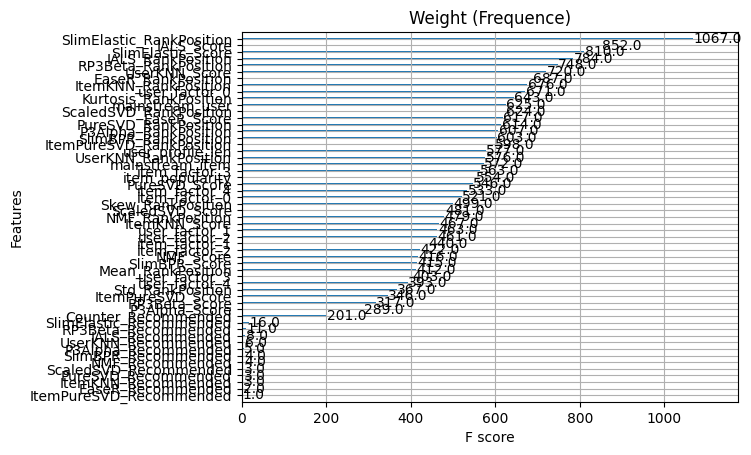

In [65]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [66]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4281.06 column/sec. Elapsed time 5.22 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 4198.74 column/sec. Elapsed time 3.10 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2810.79 column/sec. Elapsed time 7.95 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3242.66 column/sec. Elapsed time 6.89 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [67]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [68]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/446369589.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.0,1.0,0.419887,5.0,1.0,0.786014,1.0,...,0.045669,0.010442,0.052225,-0.058731,0.022079,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,111,0.082615,73.0,0.0,0.107988,15.0,0.0,0.000000,7415.0,...,0.040914,-0.012057,0.014528,-0.047855,-0.023098,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,215,0.180754,23.0,0.0,0.010770,1622.0,0.0,0.085517,21.0,...,0.035591,0.015862,-0.019037,0.043913,0.006133,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,1082,0.257622,16.0,0.0,0.025246,401.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,0.235539,18.0,0.0,0.007136,3644.0,0.0,0.064524,39.0,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,58.0,0.0,0.442709,21.0,0.0,0.073992,64.0,...,0.006622,-0.016999,0.013130,0.007500,0.036445,0.009693,-0.007923,-0.000422,0.004503,0.023066
651150,13023,732,0.576149,5.0,1.0,0.711712,0.0,1.0,0.773915,2.0,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651180,13023,685,0.047530,102.0,0.0,0.459579,17.0,0.0,0.000000,7209.0,...,0.010855,-0.026114,0.011748,0.007983,0.029280,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,2119,0.660220,2.0,1.0,0.547857,5.0,1.0,0.593510,6.0,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [69]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [70]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 123 506 403 515 1546 694 52 977
1,2,1095 12 1522 47 11 656 50 28 102 3176
2,3,59 857 4252 259 648 584 536 956 239 414
3,4,249 28 50 139 7 5 171 314 146 254
4,5,1570 77 5138 131 1511 170 95 471 1220 766
